In [160]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'ant_cons2_fast'
run_name = '2p_gamma_et'
data_dir = 'data/' + system_name + '/' + run_name + '/'

### Importing the paramters

In [161]:
env_params = ut.read_params(data_dir+'param_env.txt')
for ep in env_params:
    print(ep, env_params[ep])
alg_params = ut.read_params(data_dir+'param_alg.txt')
for ep in alg_params:
    print(ep, alg_params[ep])

max_k 10.0
n_recipients 1.0
p_succ 0.1
p_consume 0.1
init_k [11. 11.]
alg_type ac_et
gamma 0.995
stop_by_discount true
lambda_actor 0.95
lambda_critic 0.95
n_steps 40000000.0
traj_points 200.0
eval_steps 1000.0
a0 0.0005
ac 80000.0
a_expn 0.8
a_burn 13333333.333333334
b0 5e-05
bc 133333.33333333334
b_expn 0.8
b_burn 40000000.0
init_values 15.0


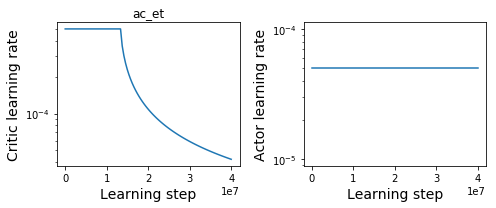

In [162]:
fig, (ax1, ax2) = ut.plot_lr(alg_params)
ax1.set_title(alg_params['alg_type'])
plt.tight_layout()
#plt.savefig('plots/'+system_name+'/'+run_name+'/learning_rates.png', dpi=200)

### Importing the trajectories

In [163]:
v_traj, h = ut.read_2d_traj(data_dir+'/value_traj.txt')
r_traj, head = ut.read_traj(data_dir+'/return_traj.txt')
info_traj, head = ut.read_traj(data_dir+'/env_info_traj.txt')

In [164]:
head

['Prob_forag_in_death',
 'Prob_forag_out_death',
 'Prob_recipients_death',
 'Prob_gamma_stop',
 'Av_return_0',
 'Av_return_1']

In [169]:
player = 1 # Player 0 for the forager, >0 for a recipient

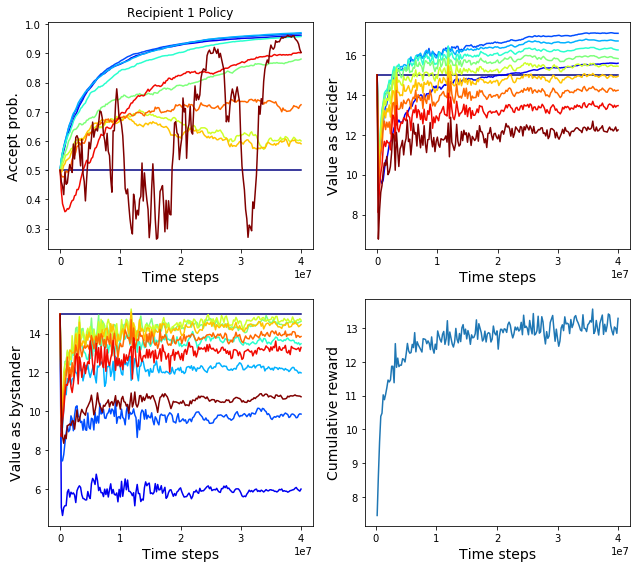

In [170]:
pol_par, h = ut.read_2d_traj(data_dir+'/policy'+str(player)+'_traj.txt')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,8))
colors = plt.cm.jet(np.linspace(0,1,int(env_params['max_k'])+1))
xs = np.linspace(0, alg_params['n_steps'], int(alg_params['traj_points']+1))

ax1.set_xlabel('Time steps', fontsize=14)
if player == 0:
    pol_str = 'Gathering'
    pl_str = 'Forager'
else:
    pol_str = 'Accept'
    pl_str = 'Recipient {}'.format(player)
ax1.set_ylabel(pol_str + ' prob.', fontsize=14)
ax1.set_title(pl_str + ' Policy')
for k in range(0,int(env_params['max_k'])+1):
    ax1.plot(xs, [p[k][0] for p in pol_par], c=colors[k], label="k={}".format(k))
#ax1.legend()

ax2.set_xlabel('Time steps', fontsize=14)
ax2.set_ylabel('Value as decider', fontsize=14)
for k in range(0,int(env_params['max_k'])+1):
    ax2.plot(xs, np.array(v_traj)[:,player,k], color=colors[k])

ax3.set_xlabel('Time steps', fontsize=14)
ax3.set_ylabel('Value as bystander', fontsize=14)
for k in range(0,int(env_params['max_k'])+1):
    ax3.plot(xs, np.array(v_traj)[:,player,k+int(env_params['max_k'])+1], c=colors[k])

ax4.set_xlabel('Time steps', fontsize=14)
ax4.set_ylabel('Cumulative reward', fontsize=14)
wind_size=500
times, new_traj = ut.smooth_traj(np.array(info_traj, dtype=float)[:,player+3], wind_size)
#ax4.set_title('Smoothed with window of {} episodes'.format(wind_size))
ax4.plot(xs[1:], np.array(info_traj,dtype=float)[1:,player+4])

plt.tight_layout()
#plt.savefig('plots/'+system_name+'/'+run_name+'/learning_'+str(player)+'.png', dpi=200)

### Time scales

In [171]:
info_traj = np.array(info_traj, dtype=float)

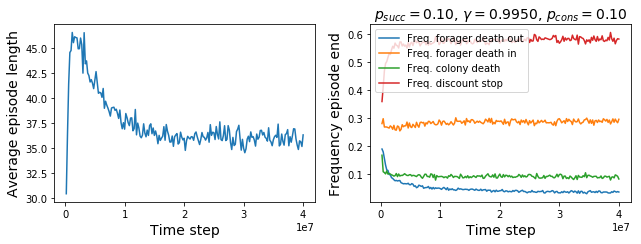

In [172]:
xs = np.linspace(0, alg_params['n_steps'], int(alg_params['traj_points']+1))[1:]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3.5))

av_length = 1/(np.array(info_traj)[1:,0]+np.array(info_traj)[1:,1]+np.array(info_traj)[1:,2]+np.array(info_traj)[1:,3])
ax1.set_xlabel('Time step', fontsize=14)
ax1.set_ylabel('Average episode length', fontsize=14)
ax1.plot(xs, av_length)

ax2.set_xlabel('Time step', fontsize=14)
ax2.set_ylabel('Frequency episode end', fontsize=14)
ax2.set_title(r"$p_{succ}=%3.2f$, $\gamma=%5.4f$, $p_{cons}=%3.2f$" %(env_params['p_succ'], alg_params['gamma'], env_params['p_consume']), fontsize=14)
ax2.plot(xs, np.array(info_traj)[1:,0]*av_length, label='Freq. forager death out')
ax2.plot(xs, np.array(info_traj)[1:,1]*av_length, label='Freq. forager death in')
ax2.plot(xs, np.array(info_traj)[1:,2]*av_length, label='Freq. colony death')
ax2.plot(xs, np.array(info_traj)[1:,3]*av_length, label='Freq. discount stop')
ax2.legend()


plt.tight_layout()
plt.savefig('plots/'+system_name+'/'+run_name+'/times.png', dpi=200)

In [148]:
ev_info, ev_info_h = ut.read_traj(data_dir+'/ev_info.txt')
ev_states, ev_states_h = ut.read_traj(data_dir+'/ev_states.txt')
print(ev_info_h, ev_states_h)

['aggr_state0', 'aggr_state1', 'action0', 'action1', 'aggr_new_state0', 'aggr_new_state1', 'reward0', 'reward1', 'done'] ['decider', 'forager_load', 'rec1_load']


In [165]:
def get_food_from_aggr(as1, as2):
    f1, f2 = as1, as2
    if as1 > env_params['max_k']:
        f1 = as1 - env_params['max_k'] - 1 
    if as2 > env_params['max_k']:
        f2 = as2 - env_params['max_k'] - 1 
    return f1, f2

In [166]:
# Finiding the first done
done_ind = 0
while True:
    if ev_info[done_ind][-1] == 1:
        done_ind += 1
        break
    done_ind += 1
    
food_trajs = []
end_reached = False
while not end_reached:
    food_traj = []
    
    while True:
        
        done_ind += 1
        if done_ind >= len(ev_info):
            end_reached = True
            break
            
        f1, f2 = get_food_from_aggr(ev_info[done_ind][0], ev_info[done_ind][1])
        food_traj.append([f1, f2])
        if ev_info[done_ind][-1] == 1:
            f1, f2 = get_food_from_aggr(ev_info[done_ind][4], ev_info[done_ind][5])
            food_traj.append([f1, f2])
            break
            
    food_trajs.append(np.array(food_traj))
    
food_trajs = food_trajs[:-1]

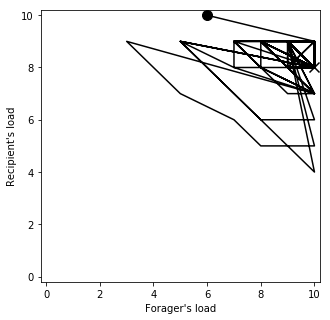

In [169]:
index = 1
plt.figure(figsize=(5,5))
plt.xlabel("Forager's load")
plt.ylabel("Recipient's load")
plt.xlim(-0.2,10.2)
plt.ylim(-0.2,10.2)
plt.plot(food_trajs[index][:,0], food_trajs[index][:,1], c='black')
plt.scatter(food_trajs[index][0,0], food_trajs[index][0,1], s=100, c='black')
plt.scatter(food_trajs[index][-1,0], food_trajs[index][-1,1], s=100, marker='x', c='black')